<a href="https://colab.research.google.com/github/ismailazdad/uwmgit/blob/main/Keras_Unet_coco_format.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook helps to create a dataset in the cocoformat and also has a visualization with with both coco and detectron API

Reference:
https://www.kaggle.com/code/ammarnassanalhajali/k-fold-crossvalidation-coco-dataset-generator/notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -rf /content/uw-madison-gi-tract-image-segmentation
!rm -rf /content/working

In [3]:
!unzip -qq /content/drive/MyDrive/UW_Madison_segmentation/train.zip -d /content/uw-madison-gi-tract-image-segmentation/

In [4]:
!unzip -qq /content/drive/MyDrive/UW_Madison_segmentation/train.csv.zip -d /content/uw-madison-gi-tract-image-segmentation/

In [5]:
!mkdir working

In [7]:
!pwd

/content


In [8]:
import pycocotools
from pycocotools import mask
import json
import numpy as np
import pycocotools.mask as mask_util
from skimage import measure
import os
from tqdm import tqdm
from tqdm.notebook import tqdm
import cv2
import random
from itertools import groupby
import itertools
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *

In [9]:
# creating a dataframe
path ="/content/uw-madison-gi-tract-image-segmentation/"
# path ="../projet 8/"
# path ="../input/uw-madison-gi-tract-image-segmentation/"

In [10]:
dataset_path = os.path.abspath(path) 
csv_path = os.path.abspath(path+"train.csv")
df = pd.read_csv(csv_path)

def fetch_file_from_id(root_dir, case_id):
    case_folder = case_id.split("_")[0]
    day_folder = "_".join(case_id.split("_")[:2])
    file_starter = "_".join(case_id.split("_")[2:])
    # fetching folder paths
    folder = os.path.join(root_dir, case_folder, day_folder, "scans")
    # fetching filenames with similar pattern
    file = glob(f"{folder}/{file_starter}*")[0]
    # returning the first file, though it will always hold one file.
    return file

# df["segmentation"] = df["segmentation"].astype("str")
df["case_id"] = df["id"].apply(lambda x: x.split("_")[0][4:])
df["day_id"] = df["id"].apply(lambda x: x.split("_")[1][3:])
df["slice_id"] = df["id"].apply(lambda x: x.split("_")[-1])
# df["path"] = df["id"].apply(lambda x: fetch_file_from_id(dataset_path, x))
df["path"] = df["id"].apply(lambda x: fetch_file_from_id(path+'/train', x))
df['path']=df.path.astype('str')
df['case_id']=df.case_id.astype('str')
df['slice_id']=df.slice_id.astype('str')
df["filename"] = df["path"].apply(lambda x: x.split('/')[-1])
df['unique_filename']  = df.apply(lambda row: str(row.case_id) +'_'+ str(row.day_id)+'_'+str(row.filename), axis=1)
df["height"] = df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[2]).astype("int")
df["width"] = df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[3]).astype("int")
df['size'] =df['height'].astype(str) +'x'+ df['width'].astype(str)



df.sample(5)

id        class  \
47356    case135_day0_slice_0122  small_bowel   
112366     case2_day4_slice_0112  small_bowel   
108699   case41_day25_slice_0042  large_bowel   
88611   case121_day16_slice_0050  large_bowel   
61181   case149_day15_slice_0122      stomach   

                                             segmentation case_id day_id  \
47356                                                 NaN     135      0   
112366  26230 3 26494 11 26760 18 27026 19 27292 20 27...       2      4   
108699                                                NaN      41     25   
88611                                                 NaN     121     16   
61181                                                 NaN     149     15   

       slice_id                                               path  \
47356      0122  /content/uw-madison-gi-tract-image-segmentatio...   
112366     0112  /content/uw-madison-gi-tract-image-segmentatio...   
108699     0042  /content/uw-madison-gi-tract-image-segmentatio...   
88611      0050  /content/uw-madison-gi-tract-image-segmentatio...   
61181      0122  /content/uw-madison-gi-tract-image-segmentatio...   

                                filename  \
47356   slice_0122_266_266_1.50_1.50.png   
112366  slice_0112_266_266_1.50_1.50.png   
108699  slice_0042_266_266_1.50_1.50.png   
88611   slice_0050_266_266_1.50_1.50.png   
61181   slice_0122_266_266_1.50_1.50.png   

                                unique_filename  height  width     size  
47356    135_0_slice_0122_266_266_1.50_1.50.png     266    266  266x266  
112366     2_4_slice_0112_266_266_1.50_1.50.png     266    266  266x266  
108699   41_25_slice_0042_266_266_1.50_1.50.png     266    266  266x266  
88611   121_16_slice_0050_266_266_1.50_1.50.png     266    266  266x266  
61181   149_15_slice_0122_266_266_1.50_1.50.png     266    266  266x266

Analyse the dataframe content

In [11]:
df.columns

Index(['id', 'class', 'segmentation', 'case_id', 'day_id', 'slice_id', 'path',
       'filename', 'unique_filename', 'height', 'width', 'size'],
      dtype='object')

In [12]:
(df.notna().mean(axis=0)*100).sort_values(ascending=True)

segmentation        29.364956
id                 100.000000
class              100.000000
case_id            100.000000
day_id             100.000000
slice_id           100.000000
path               100.000000
filename           100.000000
unique_filename    100.000000
height             100.000000
width              100.000000
size               100.000000
dtype: float64

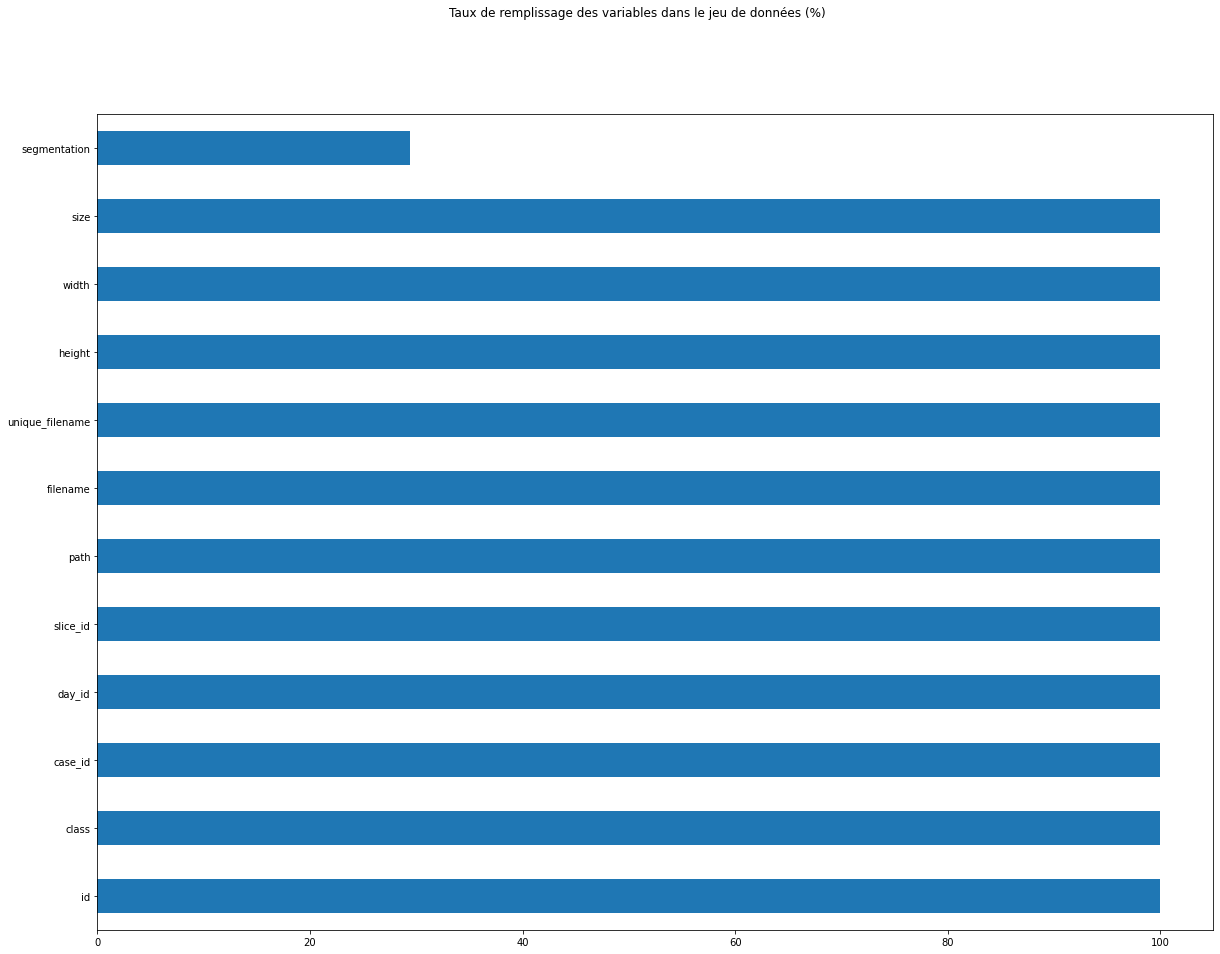

In [13]:
taux = (df.notna().mean(axis=0)*100).sort_values(ascending=False)
plt.suptitle("Taux de remplissage des variables dans le jeu de données (%)")
taux.plot(kind='barh', figsize=(20, 15))

In [14]:
# Remove misslabeled training data
df = df[(df['case_id']!=7)|(df['case_id']!=0)].reset_index(drop=True)
df = df[(df['case_id']!=81)|(df['case_id']!=30)].reset_index(drop=True)

In [15]:
df[df['segmentation'].isnull()].shape

(81575, 12)

In [16]:
df[df['segmentation'].notnull()].shape

(33913, 12)

In [17]:
df_with_mask = df[df['segmentation'].notnull()].copy() 
df_with_mask["segmentation"] = df["segmentation"].astype("str")
df_with_mask = df_with_mask.reset_index(drop=True)    

In [ ]:

df_with_mask.head()

id    class  \
0  case123_day20_slice_0065  stomach   
1  case123_day20_slice_0066  stomach   
2  case123_day20_slice_0067  stomach   
3  case123_day20_slice_0068  stomach   
4  case123_day20_slice_0069  stomach   

                                        segmentation case_id day_id slice_id  \
0  28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...     123     20     0065   
1  27561 8 27825 11 28090 13 28355 14 28620 15 28...     123     20     0066   
2  15323 4 15587 8 15852 10 16117 11 16383 12 166...     123     20     0067   
3  14792 5 15056 9 15321 11 15587 11 15852 13 161...     123     20     0068   
4  14526 6 14789 12 15054 14 15319 16 15584 17 15...     123     20     0069   

                                                path  \
0  /content/uw-madison-gi-tract-image-segmentatio...   
1  /content/uw-madison-gi-tract-image-segmentatio...   
2  /content/uw-madison-gi-tract-image-segmentatio...   
3  /content/uw-madison-gi-tract-image-segmentatio...   
4  /content/uw-madison-gi-tract-image-segmentatio...   

                           filename                          unique_filename  \
0  slice_0065_266_266_1.50_1.50.png  123_20_slice_0065_266_266_1.50_1.50.png   
1  slice_0066_266_266_1.50_1.50.png  123_20_slice_0066_266_266_1.50_1.50.png   
2  slice_0067_266_266_1.50_1.50.png  123_20_slice_0067_266_266_1.50_1.50.png   
3  slice_0068_266_266_1.50_1.50.png  123_20_slice_0068_266_266_1.50_1.50.png   
4  slice_0069_266_266_1.50_1.50.png  123_20_slice_0069_266_266_1.50_1.50.png   

   height  width     size  
0     266    266  266x266  
1     266    266  266x266  
2     266    266  266x266  
3     266    266  266x266  
4     266    266  266x266

In [ ]:
# df_with_mask = pd.read_csv('/content/drive/MyDrive/UW_Madison_segmentation/df_with_mask.csv')

Text(0.5, 1.0, 'repartition of case')

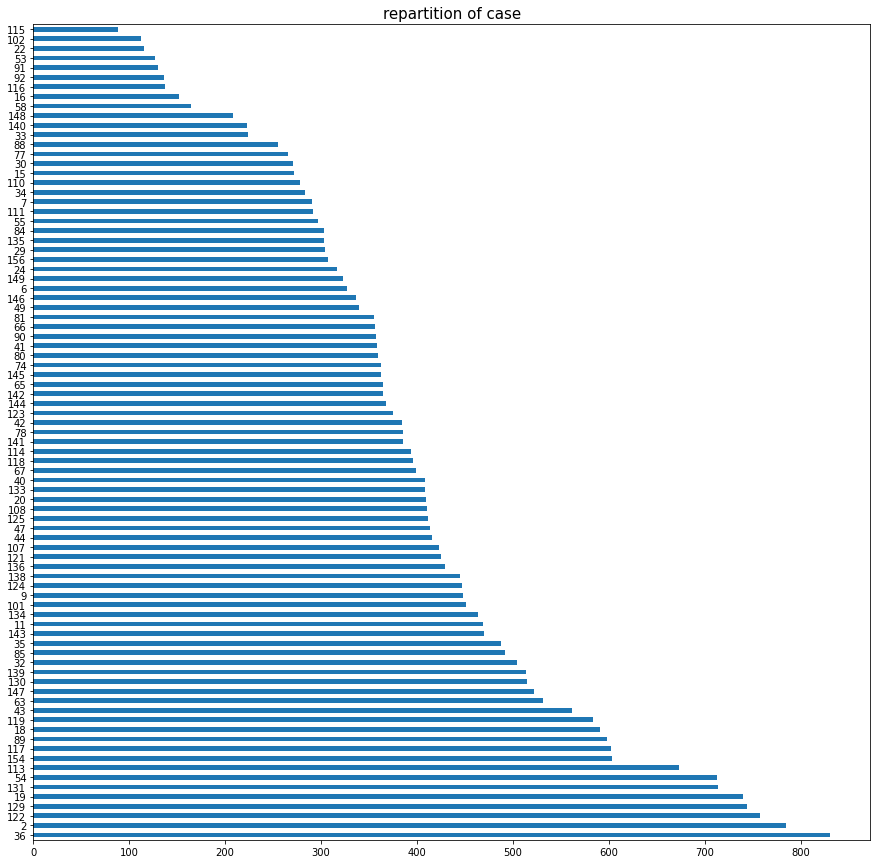

In [18]:
fig = plt.figure(figsize=(15, 15))
df_with_mask['case_id'].value_counts().plot(kind='barh')
plt.title(str('repartition of case'),fontsize=15)

Text(0.5, 1.0, 'repartition of days traitment')

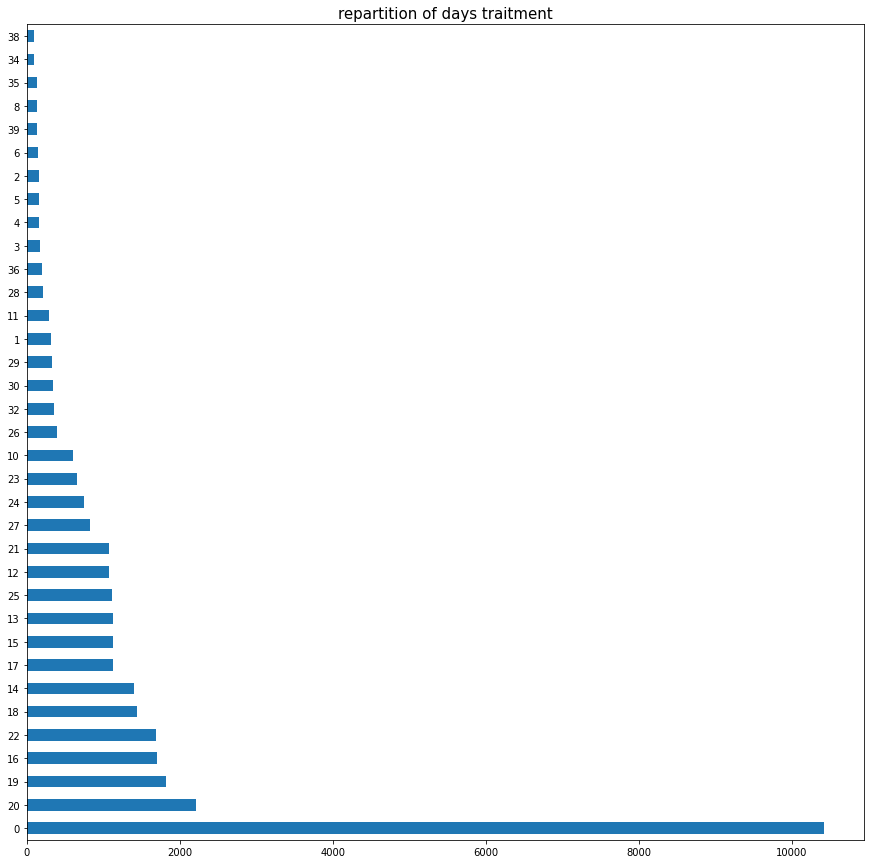

In [19]:
fig = plt.figure(figsize=(15, 15))
df_with_mask['day_id'].value_counts().plot(kind='barh')
plt.title(str('repartition of days traitment'),fontsize=15)

Text(0.5, 1.0, 'repartition of slice_id ')

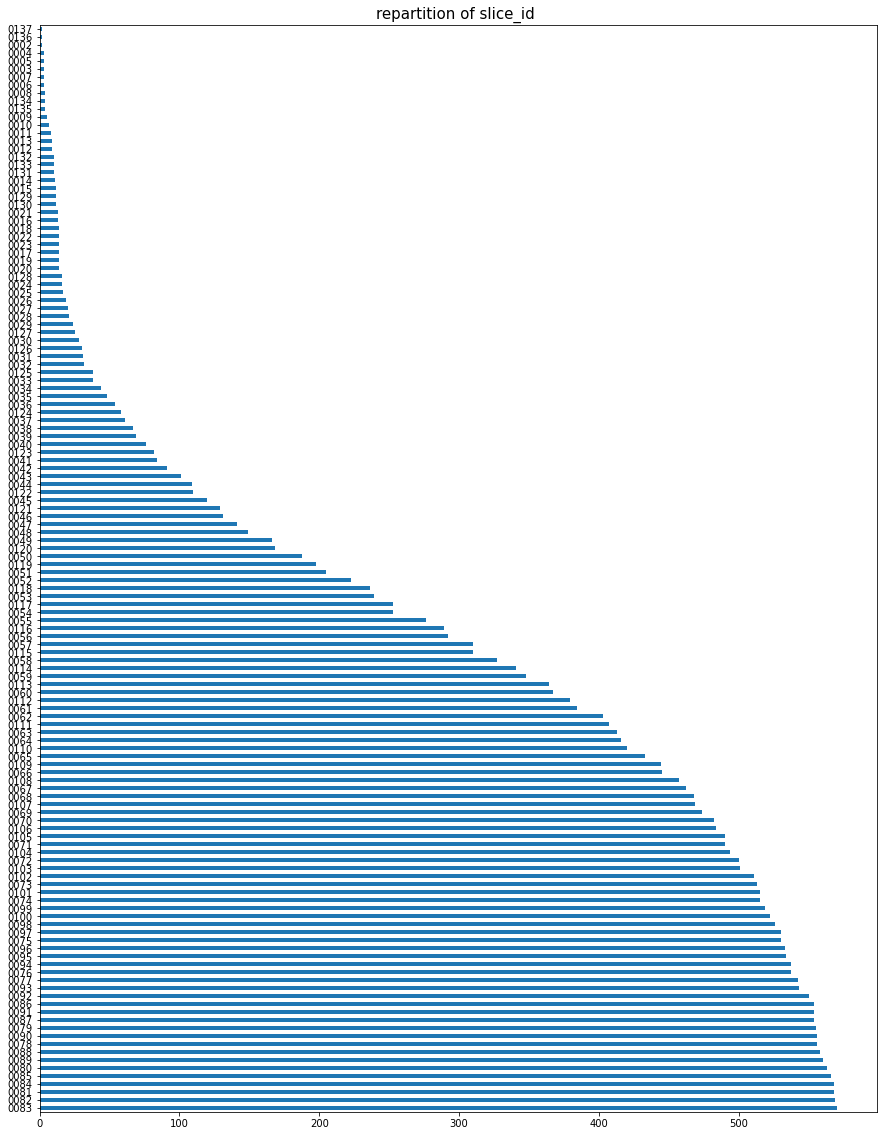

In [20]:
fig = plt.figure(figsize=(15, 20))
df_with_mask['slice_id'].value_counts().plot(kind='barh')
plt.title(str('repartition of slice_id '),fontsize=15)

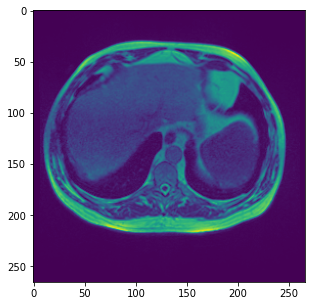

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig = plt.figure(figsize=(5, 5))
img = mpimg.imread(df_with_mask.path[0])
imgplot = plt.imshow(img)
plt.show()

In [22]:
df_with_mask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33913 entries, 0 to 33912
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               33913 non-null  object
 1   class            33913 non-null  object
 2   segmentation     33913 non-null  object
 3   case_id          33913 non-null  object
 4   day_id           33913 non-null  object
 5   slice_id         33913 non-null  object
 6   path             33913 non-null  object
 7   filename         33913 non-null  object
 8   unique_filename  33913 non-null  object
 9   height           33913 non-null  int64 
 10  width            33913 non-null  int64 
 11  size             33913 non-null  object
dtypes: int64(2), object(10)
memory usage: 3.1+ MB


In [23]:
df_with_mask['size'].value_counts()

266x266    22328
360x310     9911
276x276     1557
234x234      117
Name: size, dtype: int64

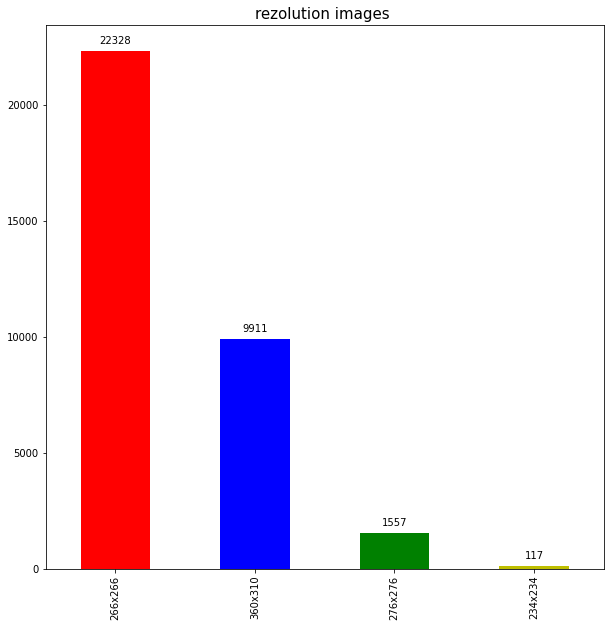

In [25]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = df_with_mask['size'].value_counts().plot(kind='bar', color=['r','b','g','y']) 

for p in ax.patches:
    ax.annotate(s=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.title(str('rezolution images '),fontsize=15)
plt.show()

In [26]:
df_with_mask['class'].value_counts()

large_bowel    14085
small_bowel    11201
stomach         8627
Name: class, dtype: int64

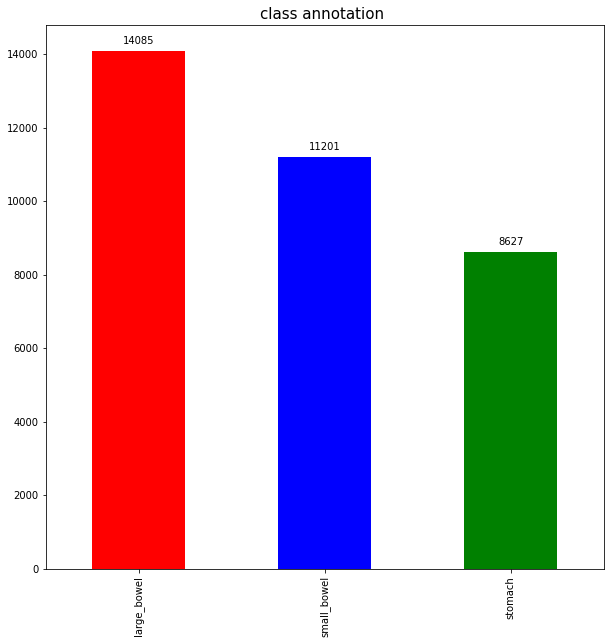

In [27]:
fig = plt.figure(figsize=(10, 10))
ax = df_with_mask['class'].value_counts().plot(kind='bar', color=['r','b','g']) 

for p in ax.patches:
    ax.annotate(s=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.title(str('class annotation '),fontsize=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 2880x2880 with 0 Axes>

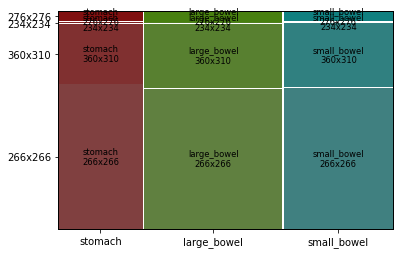

<Figure size 2880x2880 with 0 Axes>

In [29]:
from statsmodels.graphics.mosaicplot import mosaic

plt.rcParams['font.size'] = 10.0
mosaic(df_with_mask, ['class', 'size'], )
plt.figure(figsize=(40,40))

Text(0.5, 1.0, 'class annotation by case')

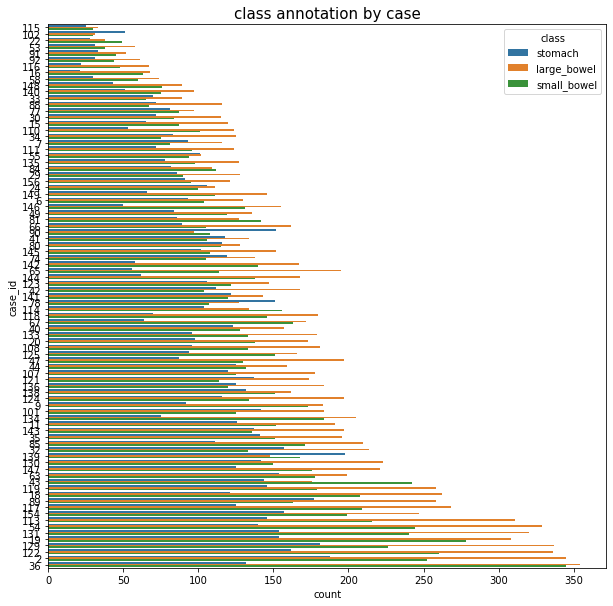

In [28]:
plt.figure(figsize=(10,10))
ordre_quartier = df_with_mask.groupby('case_id')['class'].count().sort_values().index
sns.countplot(y="case_id",hue="class",data=df_with_mask, order=ordre_quartier)
plt.title(str('class annotation by case'),fontsize=15)

In [30]:
df_with_mask.to_csv('/content/drive/MyDrive/UW_Madison_segmentation/df_with_mask.csv')

In [31]:
df_with_mask[df_with_mask['id']=='case121_day0_slice_0107']

id        class  \
26418  case121_day0_slice_0107  large_bowel   
26419  case121_day0_slice_0107  small_bowel   

                                            segmentation case_id day_id  \
26418  16886 6 17148 13 17410 19 17673 30 17936 37 18...     121      0   
26419  21709 4 21972 11 22238 16 22503 21 22769 23 23...     121      0   

      slice_id                                               path  \
26418     0107  /content/uw-madison-gi-tract-image-segmentatio...   
26419     0107  /content/uw-madison-gi-tract-image-segmentatio...   

                               filename  \
26418  slice_0107_266_266_1.50_1.50.png   
26419  slice_0107_266_266_1.50_1.50.png   

                              unique_filename  height  width     size  
26418  121_0_slice_0107_266_266_1.50_1.50.png     266    266  266x266  
26419  121_0_slice_0107_266_266_1.50_1.50.png     266    266  266x266

In [32]:
df_with_mask.shape

(33913, 12)

In [33]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

# From https://newbedev.com/encode-numpy-array-using-uncompressed-rle-for-coco-dataset
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle


# thanks to mohandass
# https://www.kaggle.com/code/mohanrobotics/cocoformat-dataset-creation-instance-segmentation
# i made some change to the id , the pycotools need numeric array id and not a string to work correctly
def create_coco_format_json(data_frame, classes, filepaths):
    images = []
    annotations = []
    categories = []
    count = 0
    
    # Additing categories
    for idx, class_ in enumerate(classes):
        categories.append(
            { 
                "id": idx,
                "name": class_
            }
        )
    i = 0
    for filepath in tqdm(filepaths):
        i += 1   
        image_id = i     
        file_id = ('_'.join((filepath.split("/")[-3] + "_" + filepath.split("/")[-1]).split("_")[:-4]))
        height_slice = int(filepath.split("/")[-1].split("_")[3])
        width_slice = int(filepath.split("/")[-1].split("_")[2])
        ids = data_frame.index[data_frame['id'] == file_id].tolist()
        # file_name = '/'.join(filepath.split("/")[2:])
        file_name = '/'.join(filepath.split("/")[3:])
        # print('/'.join(filepath.split("/")[2:]))
        if (len(ids) > 0):
            # Adding images which has annotations
            images.append(
                {
                    "id": image_id,
                    "file_id":file_id,#add id of the dataframe
                    "width":width_slice,
                    "height":height_slice,
                    "file_name": filepath
                }
            )
            for idx in ids:
                mk = rle_decode(data_frame.iloc[idx]['segmentation'], (height_slice, width_slice))
                ys, xs = np.where(mk)
                x1, x2 = min(xs), max(xs)
                y1, y2 = min(ys), max(ys)              
                contours,hierarchy = cv2.findContours(mk,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
                for id_, contour in enumerate(contours):
                    mask_image = np.zeros((mk.shape[0], mk.shape[1], 3),  np.uint8)
                    cv2.drawContours(mask_image, [contour], -1, (255,255,255), thickness=cv2.FILLED)
                    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
                    mask_image_bool = np.array(mask_image, dtype=bool).astype(np.uint8)
                    ys, xs = np.where(mask_image_bool)
                    x1, x2 = min(xs), max(xs)
                    y1, y2 = min(ys), max(ys)
                    enc =binary_mask_to_rle(mask_image_bool)
                    seg = {
                        'segmentation':enc, 
                        'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
                        'area': int(np.sum(mask_image_bool)),
                        'image_id':image_id, 
                        'category_id':classes.index(data_frame.iloc[idx]['class']), 
                        'iscrowd':0, 
                        'id': count
                    }
                    annotations.append(seg)
                    count +=1        
    # creating the dataset
    dataset_coco_format = {
        "categories": categories,
        "images": images,
        "annotations": annotations,
    }
    
    return dataset_coco_format

In [41]:
# Creation of train test split
train_df, test_df = train_test_split(df_with_mask, test_size=0.2)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(train_df.head())
print("\n \nNumber of Train Images:{}".format(len(train_df)))
print("Number of Test Images:{}".format(len(test_df)))


 
Number of Train Images:27130
Number of Test Images:6783


In [42]:
train_df.to_csv('/content/drive/MyDrive/UW_Madison_segmentation/train_df.csv')
test_df.to_csv('/content/drive/MyDrive/UW_Madison_segmentation/test_df.csv')

In [35]:
# test_df = pd.read_csv('/content/drive/MyDrive/UW_Madison_segmentation/test_df.csv')
# train_df = pd.read_csv('/content/drive/MyDrive/UW_Madison_segmentation/train_df.csv')
# test_df = test_df.reset_index(drop=True)
# train_df = train_df.reset_index(drop=True)

In [43]:
indexes = test_df['id'].value_counts().sort_values(ascending=False).to_frame().iloc[:1000,:].index

In [44]:
tmp_df = test_df[test_df['id'].isin(indexes)].sample(16)
tmp_df = tmp_df.reset_index(drop=True)
tmp_df.sort_values(['unique_filename']).sample(3)

id        class  \
5   case35_day12_slice_0068  large_bowel   
11  case81_day30_slice_0095      stomach   
15  case20_day24_slice_0075  large_bowel   

                                         segmentation case_id day_id slice_id  \
5   23307 5 23582 8 23857 11 24133 12 24161 5 2440...      35     12     0068   
11  23802 6 24067 9 24332 13 24597 26 24863 27 251...      81     30     0095   
15  16388 5 16653 10 16918 14 17184 16 17449 21 17...      20     24     0075   

                                                 path  \
5   /content/uw-madison-gi-tract-image-segmentatio...   
11  /content/uw-madison-gi-tract-image-segmentatio...   
15  /content/uw-madison-gi-tract-image-segmentatio...   

                            filename                         unique_filename  \
5   slice_0068_276_276_1.63_1.63.png  35_12_slice_0068_276_276_1.63_1.63.png   
11  slice_0095_266_266_1.50_1.50.png  81_30_slice_0095_266_266_1.50_1.50.png   
15  slice_0075_266_266_1.50_1.50.png  20_24_slice_0075_266_266_1.50_1.50.png   

    height  width     size  
5      276    276  276x276  
11     266    266  266x266  
15     266    266  266x266

In [45]:
classes = ['small_bowel', 'large_bowel', 'stomach']
tmp_json = create_coco_format_json(tmp_df, classes, tmp_df['path'].tolist())

100%|██████████| 16/16 [00:00<00:00, 58.05it/s]


In [46]:
str(tmp_json)

"{'categories': [{'id': 0, 'name': 'small_bowel'}, {'id': 1, 'name': 'large_bowel'}, {'id': 2, 'name': 'stomach'}], 'images': [{'id': 1, 'file_id': 'case143_day0_slice_0121', 'width': 266, 'height': 266, 'file_name': '/content/uw-madison-gi-tract-image-segmentation/case143/case143_day0/scans/slice_0121_266_266_1.50_1.50.png'}, {'id': 2, 'file_id': 'case135_day0_slice_0059', 'width': 266, 'height': 266, 'file_name': '/content/uw-madison-gi-tract-image-segmentation/case135/case135_day0/scans/slice_0059_266_266_1.50_1.50.png'}, {'id': 3, 'file_id': 'case117_day17_slice_0009', 'width': 276, 'height': 276, 'file_name': '/content/uw-madison-gi-tract-image-segmentation/case117/case117_day17/scans/slice_0009_276_276_1.63_1.63.png'}, {'id': 4, 'file_id': 'case119_day20_slice_0102', 'width': 266, 'height': 266, 'file_name': '/content/uw-madison-gi-tract-image-segmentation/case119/case119_day20/scans/slice_0102_266_266_1.50_1.50.png'}, {'id': 5, 'file_id': 'case147_day19_slice_0093', 'width': 266

In [47]:
# Code taken from: https://stackoverflow.com/a/65151218/12890869
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

with open('working/tmp_json.json', 'w', encoding='utf-8') as f:
    json.dump(tmp_json, f, ensure_ascii=True, indent=4, default=np_encoder)        

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


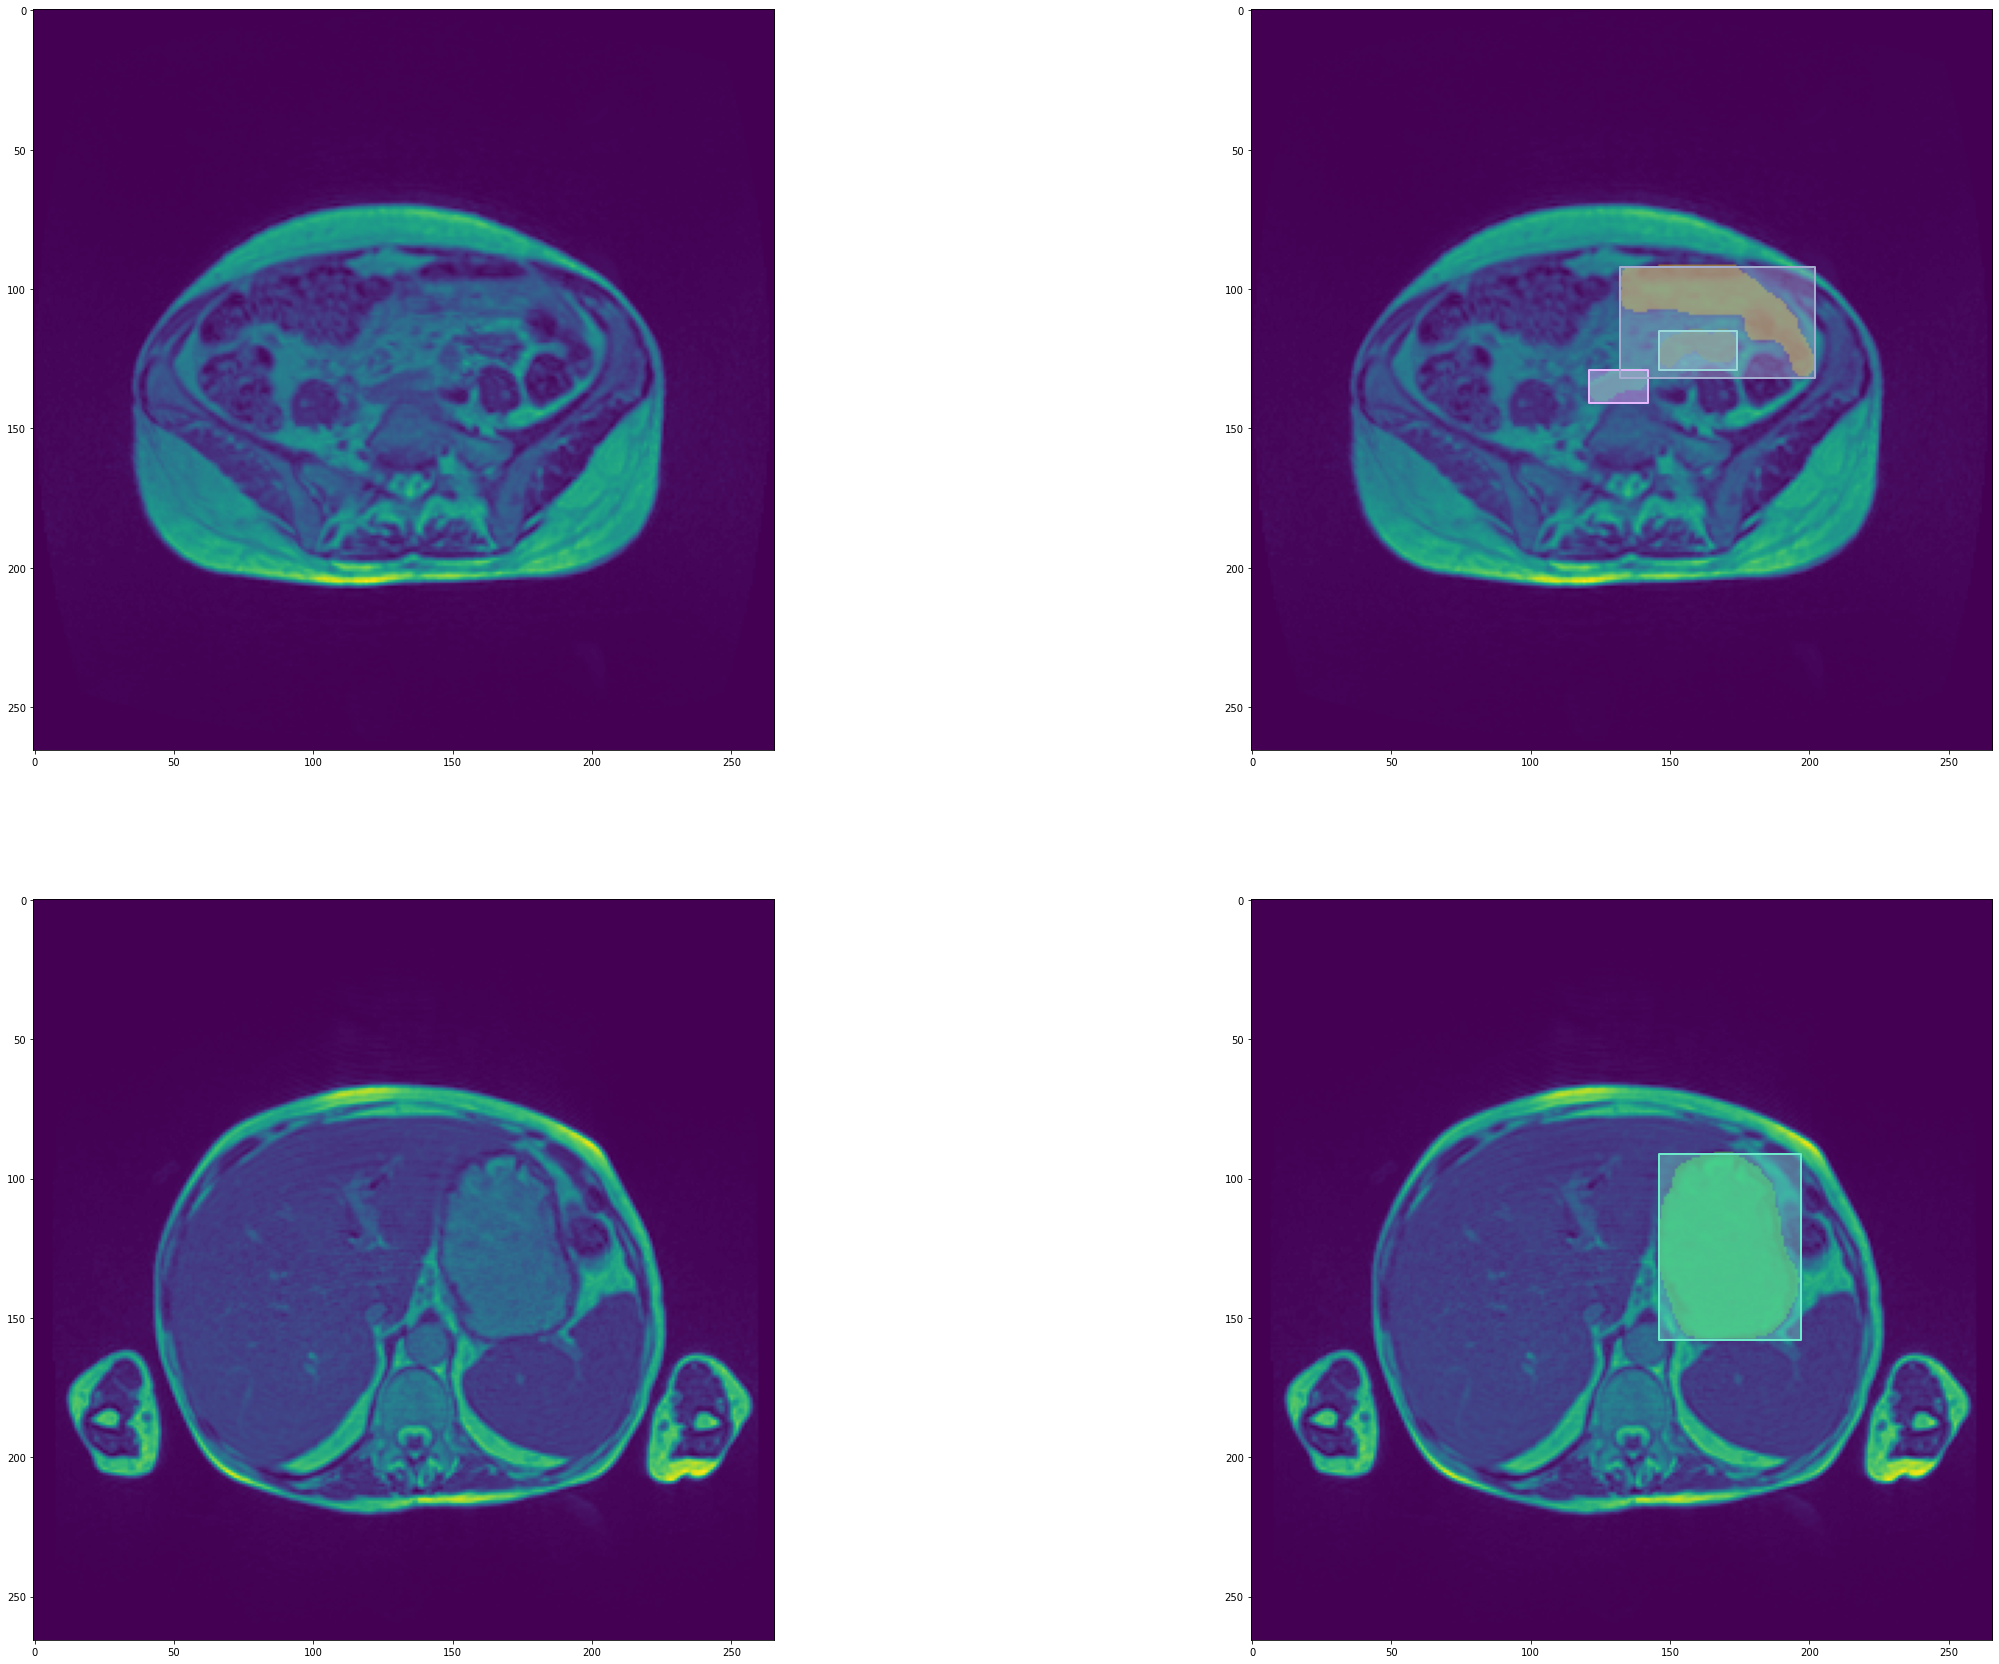

In [48]:
annFile = Path(f'/content/working/tmp_json.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()


imgs = coco.loadImgs(imgIds[0:2])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.fromarray(np.array(Image.open(img['file_name'])).astype("uint16"))
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

In [49]:

import pandas as pd
info = coco.dataset

for k, v in info.items():
    if isinstance(v, int):
        info[k] = [v]
dataframe = pd.DataFrame.from_dict(info, orient='index')
dataframe

0   \
categories                    {'id': 0, 'name': 'small_bowel'}   
images       {'id': 1, 'file_id': 'case143_day0_slice_0121'...   
annotations  {'segmentation': {'counts': [32320, 5, 261, 6,...   

                                                            1   \
categories                    {'id': 1, 'name': 'large_bowel'}   
images       {'id': 2, 'file_id': 'case135_day0_slice_0059'...   
annotations  {'segmentation': {'counts': [38958, 5, 259, 8,...   

                                                            2   \
categories                        {'id': 2, 'name': 'stomach'}   
images       {'id': 3, 'file_id': 'case117_day17_slice_0009...   
annotations  {'segmentation': {'counts': [35208, 4, 1, 4, 2...   

                                                            3   \
categories                                                None   
images       {'id': 4, 'file_id': 'case119_day20_slice_0102...   
annotations  {'segmentation': {'counts': [38951, 19, 242, 2...   

                                                            4   \
categories                                                None   
images       {'id': 5, 'file_id': 'case147_day19_slice_0093...   
annotations  {'segmentation': {'counts': [51456, 7, 260, 21...   

                                                            5   \
categories                                                None   
images       {'id': 6, 'file_id': 'case35_day12_slice_0068'...   
annotations  {'segmentation': {'counts': [47828, 7, 268, 9,...   

                                                            6   \
categories                                                None   
images       {'id': 7, 'file_id': 'case36_day14_slice_0104'...   
annotations  {'segmentation': {'counts': [4889, 3, 260, 9, ...   

                                                            7   \
categories                                                None   
images       {'id': 8, 'file_id': 'case117_day13_slice_0011...   
annotations  {'segmentation': {'counts': [52183, 8, 256, 11...   

                                                            8   \
categories                                                None   
images       {'id': 9, 'file_id': 'case133_day25_slice_0106...   
annotations  {'segmentation': {'counts': [31959, 7, 258, 9,...   

                                                            9   ...  \
categories                                                None  ...   
images       {'id': 10, 'file_id': 'case136_day25_slice_007...  ...   
annotations  {'segmentation': {'counts': [22462, 6, 259, 9,...  ...   

                                                            30  \
categories                                                None   
images                                                    None   
annotations  {'segmentation': {'counts': [33076, 8, 257, 11...   

                                                            31  \
categories                                                None   
images                                                    None   
annotations  {'segmentation': {'counts': [73598, 2, 307, 6,...   

                                                            32  \
categories                                                None   
images                                                    None   
annotations  {'segmentation': {'counts': [58416, 8, 300, 11...   

                                                            33  \
categories                                                None   
images                                                    None   
annotations  {'segmentation': {'counts': [53443, 6, 303, 8,...   

                                                            34  \
categories                                                None   
images                                                    None   
annotations  {'segmentation': {'counts': [20063, 8, 257, 14...   

                                                            35  \

In [50]:
classes = ['small_bowel', 'large_bowel', 'stomach']

train_json = create_coco_format_json(train_df, classes, train_df['path'].tolist())
test_json = create_coco_format_json(test_df, classes, test_df['path'].tolist())

100%|██████████| 6783/6783 [02:24<00:00, 46.87it/s]


In [51]:
with open('working/train_json.json', 'w', encoding='utf-8') as f:
    json.dump(train_json, f, ensure_ascii=True, indent=4, default=np_encoder)   
    
with open('working/test_json.json', 'w', encoding='utf-8') as f:
    json.dump(test_json, f, ensure_ascii=True, indent=4, default=np_encoder)

In [ ]:
# !cp '/content/drive/MyDrive/UW_Madison_segmentation/train_json.json' '/content/working/train_json.json'
# !cp '/content/drive/MyDrive/UW_Madison_segmentation/test_json.json' '/content/working/test_json.json'

In [209]:
# !cp /content/working/train_json.json /content/drive/MyDrive/UW_Madison_segmentation/train_json.json
# !cp /content/working/test_json.json /content/drive/MyDrive/UW_Madison_segmentation/test_json.json

In [ ]:

# train_json = json.load(open('/content/drive/MyDrive/UW_Madison_segmentation/train_json.json', 'r'))
# test_json = json.load(open('/content/drive/MyDrive/UW_Madison_segmentation/test_json.json', 'r'))

train_json = json.load(open('/content/working/train_json.json', 'r'))
test_json = json.load(open('/content/working/test_json.json', 'r'))

In [53]:
MASK_TRAIN_DIR = '/content/working/'
IMAGE_TRAIN_DIR = '/content/uw-madison-gi-tract-image-segmentation/'
ANNOTATION_FILE_VAL = (MASK_TRAIN_DIR+'test_json.json')
ANNOTATION_FILE_TRAIN = (MASK_TRAIN_DIR+'train_json.json')

coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds() 
imgIds_train = coco_train.getImgIds() 
imgDict_train = coco_train.loadImgs(imgIds_train) 
print(len(imgIds_train) , len(catIds_train))

coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds()
imgIds_val = coco_val.getImgIds()
imgDict_val = coco_val.loadImgs(imgIds_val)
print(len(imgIds_val) , len(catIds_val))

loading annotations into memory...
Done (t=3.52s)
creating index...
index created!
27130 3
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
6783 3


In [ ]:
path

'/content/uw-madison-gi-tract-image-segmentation/'

case130_day20_slice_0067
case117_day17_slice_0026
case89_day21_slice_0041
case107_day19_slice_0052
case107_day19_slice_0079


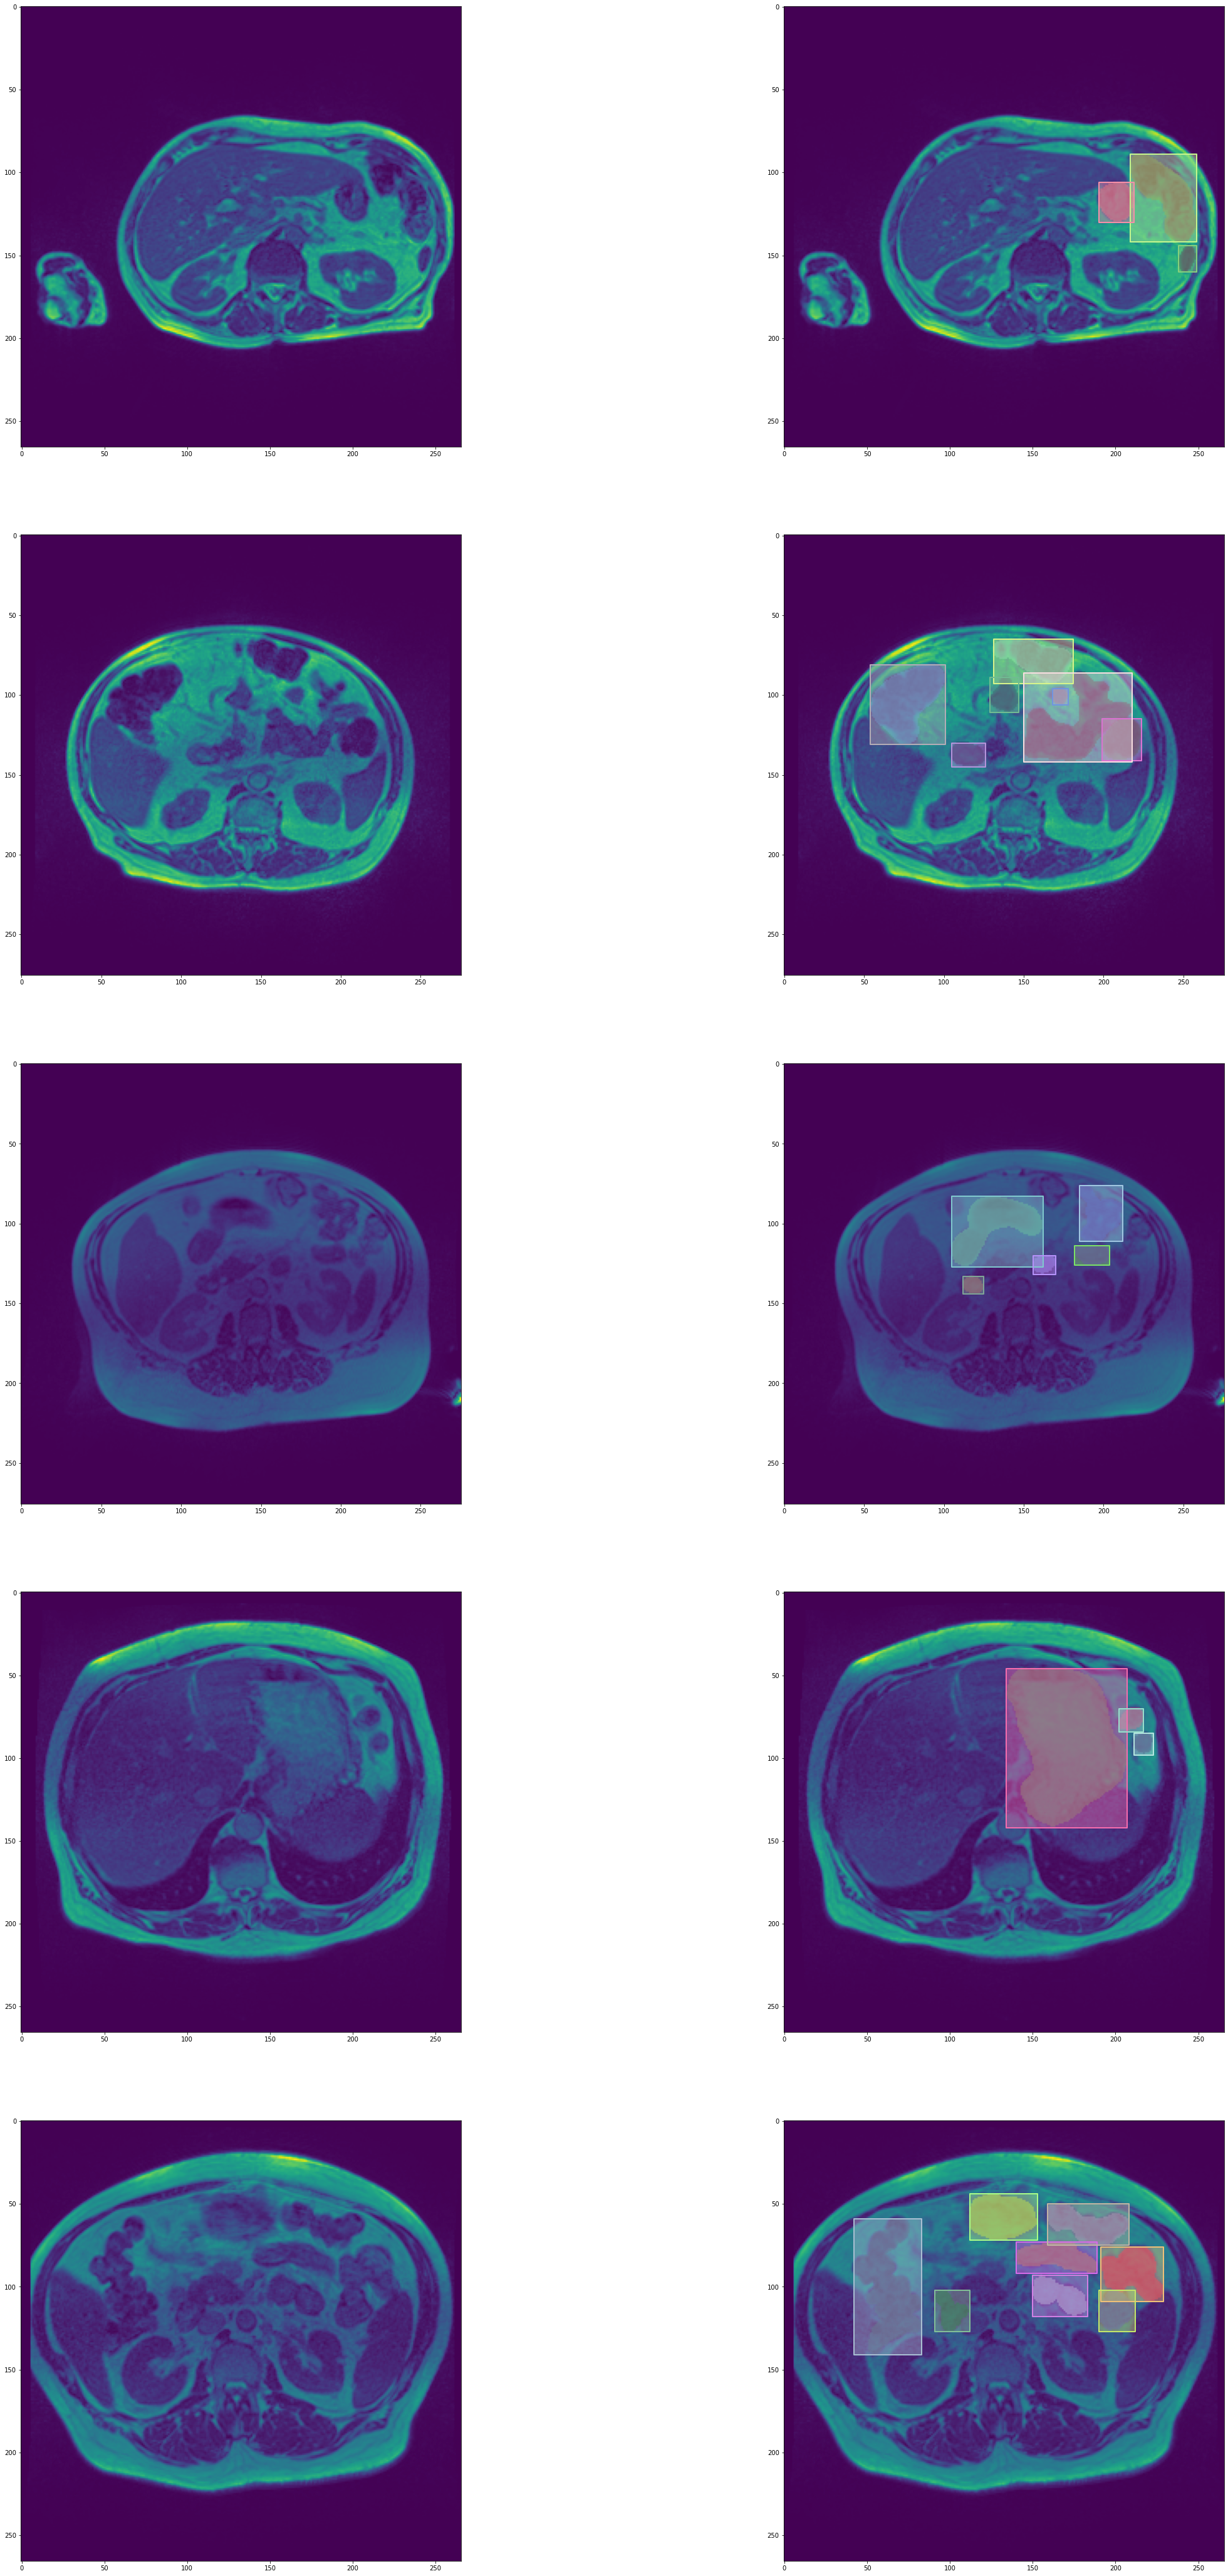

In [67]:
imgs = coco_train.loadImgs(imgIds_train[0:5])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    print(img['file_id'])
    I = Image.open(img['file_name'])
    I = Image.fromarray(np.array(Image.open(img['file_name'])).astype("uint16"))
    annIds = coco_train.getAnnIds(imgIds=[img['id']])
    anns = coco_train.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco_train.showAnns(anns, draw_bbox=True)

In [ ]:
# !rm -rf /content/working

In [ ]:
# !mkdir /content/working

In [ ]:
# !zip -qq -r /content/working.zip /content/working/

In [ ]:
# !cp /content/working.zip /content/drive/MyDrive/UW_Madison_segmentation/working.zip

In [ ]:
# def make_mask(df,imgIds,MASK_TRAIN_DIR,IMAGE_TRAIN_DIR,coco):
#   count = 0 
#   unfitted_image_dict = []
#   for ID in tqdm(imgIds):
#     file_path = df[df.index==ID].iloc[0]['path']
#     file_name = file_path.split("/")[-1:][0]
#     file_path = file_path.replace(file_name,'').replace(IMAGE_TRAIN_DIR,MASK_TRAIN_DIR)
#     sampleImgIds = coco.getImgIds(imgIds = [ID])
#     sampleImgDict = coco.loadImgs(sampleImgIds)[0]
#     annIds = coco.getAnnIds(imgIds=sampleImgDict['id'], 
#                                 iscrowd=0)
#     anns = coco.loadAnns(annIds)
#     # separating images with background as the only mask
#     if len(anns)==0:
#         unfitted_image_dict.append(sampleImgDict)
#     else:
#         mask = coco.annToMask(anns[0])
#         # unify all the masks provided
#         for i in (range(len(anns))):
#             mask = mask | coco.annToMask(anns[i])
#         mask = Image.fromarray(mask * 255 , mode = "L")
#         # save the mask
#         os.makedirs(file_path, exist_ok=True)
#         mask.save(file_path+file_name)
#         count = count + 1
#   print(count)


# make_mask(train_df,imgIds_train,MASK_TRAIN_DIR,IMAGE_TRAIN_DIR,coco_train)
# make_mask(test_df,imgIds_val,MASK_TRAIN_DIR,IMAGE_TRAIN_DIR,coco_val)

In [68]:
# use image size 128 for better results 
image_size = 128 
epochs = 10
batch_size = 8

In [71]:
# display COCO categories and supercategories
annFile = Path(f'/content/working/tmp_json.json')
coco = COCO(annFile)
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
imgIds = coco.getImgIds() 
imgDict = coco_train.loadImgs(imgIds) 


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [57]:
nms=[cat['name'] for cat in cats]
print(len(nms),'categories: \n{}\n'.format(' '.join(nms)))

3 categories: 
small_bowel large_bowel stomach



In [58]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

print('The class name is', getClassName(0, cats))
print('The class name is', getClassName(1, cats))
print('The class name is', getClassName(2, cats))

The class name is small_bowel
The class name is large_bowel
The class name is stomach


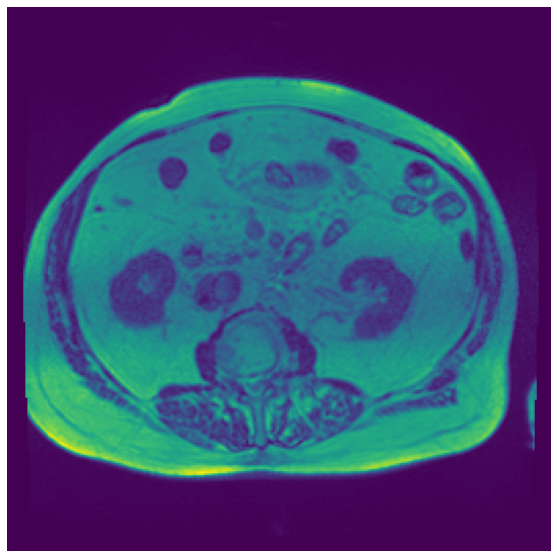

In [72]:
# load and display image
plt.figure(figsize=(10,10)) 
import skimage.io as io 
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0] 
I = io.imread(img['file_name'])/255.0

# Or use url to load image
plt.axis('off') 
plt.imshow(I) 
plt.show( )

In [73]:
img

{'file_id': 'case147_day19_slice_0093',
 'file_name': '/content/uw-madison-gi-tract-image-segmentation/case147/case147_day19/scans/slice_0093_266_266_1.50_1.50.png',
 'height': 266,
 'id': 5,
 'width': 266}

In [61]:
########## ALl POSSIBLE COMBINATIONS ########
classes = ['small_bowel', 'large_bowel', 'stomach']

images = []
if classes!=None:
    # iterate for each individual class in the list
    for className in classes:
        # get all images containing given class
        catIds = coco_train.getCatIds(catNms=className)
        imgIds = coco_train.getImgIds(catIds=catIds)
        images += coco_train.loadImgs(imgIds)
else:
    imgIds = coco_train.getImgIds()
    images = coco_train.loadImgs(imgIds)
    
# Now, filter out the repeated images    
unique_images = []
for i in range(len(images)):
    if images[i] not in unique_images:
        unique_images.append(images[i])

dataset_size = len(unique_images)

print("Number of images containing the filter classes:", dataset_size)

Number of images containing the filter classes: 27130


In [63]:
unique_images[0]

{'file_id': 'case117_day17_slice_0026',
 'file_name': '/content/uw-madison-gi-tract-image-segmentation/case117/case117_day17/scans/slice_0026_276_276_1.63_1.63.png',
 'height': 276,
 'id': 2,
 'width': 276}

Normal Mask

Unique pixel values in the mask are: [0. 1. 2. 3.]


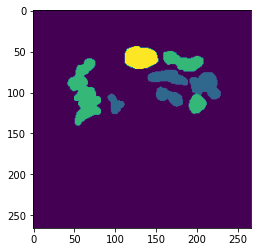

In [74]:
#### GENERATE A SEGMENTATION MASK ####
filterClasses =  ['small_bowel', 'large_bowel', 'stomach']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco_train.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

print('Unique pixel values in the mask are:', np.unique(mask))

Binary Masking

Unique pixel values in the mask are: [0. 1.]


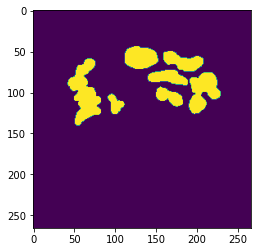

In [75]:
#### GENERATE BINARY MASK ####

mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(coco_train.annToMask(anns[i]), mask)
plt.imshow(mask)

print('Unique pixel values in the mask are:', np.unique(mask))

In [76]:
def filterDataset( classes=None, json_file=None):    
    # initialize COCO api for instance annotations
    annFile = json_file
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [77]:
classes = ['small_bowel', 'large_bowel', 'stomach']

images_tmp, dataset_size_tmp, coco = filterDataset( classes,  '/content/working/tmp_json.json')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [78]:
classes = ['small_bowel', 'large_bowel', 'stomach']
images_train, dataset_size_train, coco_train = filterDataset( classes,  '/content/working/train_json.json')
images_test, dataset_size_test, coco_val = filterDataset( classes,  '/content/working/test_json.json')

loading annotations into memory...
Done (t=2.87s)
creating index...
index created!
loading annotations into memory...
Done (t=1.60s)
creating index...
index created!


In [79]:
images_tmp[0]

{'file_id': 'case136_day25_slice_0078',
 'file_name': '/content/uw-madison-gi-tract-image-segmentation/case136/case136_day25/scans/slice_0078_360_310_1.50_1.50.png',
 'height': 310,
 'id': 10,
 'width': 360}

In [80]:
batch_size = 8
input_image_size = (128,128)
mask_type = 'normal' 
classes = ['small_bowel', 'large_bowel', 'stomach']

In [226]:
class DataGeneratorFromCocoJson(tf.keras.utils.Sequence):
  # function getting info dataset from json coco
  # Batch size
  # subset train or test for annotations
  # image_list to develop... 
  # classes classe wanted
  # input image size tuple (X,X)
  # annFile path to annoted coco json file file 
    def __init__(self, batch_size = batch_size, subset="train",image_list=[]
                 ,classes=[], input_image_size=(128,128),annFile='',shuffle=False):
      
        super().__init__()
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(image_list))
        self.image_list= image_list
        self.classes= classes
        self.input_image_size= (input_image_size)
        self.dataset_size = len(image_list)
        self.coco = COCO(annFile)
        catIds = self.coco.getCatIds(catNms=self.classes)
        self.catIds = catIds  
        self.cats = self.coco.loadCats(catIDs)
        self.imgIds = self.coco.getImgIds()
        self.shuffle = shuffle
        self.on_epoch_end()
  

    def __len__(self):
      return int(len(self.image_list)/self.batch_size)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)      


    def getClassName(self,classID, cats):
        for i in range(len(cats)):
            if cats[i]['id']==classID:
                return cats[i]['name']
        return None
  
    def getNormalMask(self,image_id,catIds):
        annIds = self.coco.getAnnIds(image_id, catIds=catIds, iscrowd=None)
        anns = self.coco.loadAnns(annIds)
        cats = self.coco.loadCats(catIds)
        train_mask = np.zeros(self.input_image_size,dtype=np.uint8)
        for a in range(len(anns)):
            className = self.getClassName(anns[a]['category_id'], cats)
            pixel_value = self.classes.index(className)+1
            new_mask = cv2.resize(self.coco.annToMask(anns[a])*pixel_value, self.input_image_size)
            train_mask = np.maximum(new_mask, train_mask)
            # train_mask = new_mask / 255.0
        return train_mask          
        

    def getLevelsMask(self,image_id):
      #for each category , we get the x mask and add it to mask list
      res = []  
      mask = np.zeros((self.input_image_size))
      for j,categorie in enumerate(self.catIds):
        annIds = coco.getAnnIds(image_id, catIds=categorie, iscrowd=None)
        anns = coco.loadAnns(annIds)
        mask = self.getNormalMask(image_id,categorie)
        res.append( mask)
      return res       

    def getImage(self,file_path):
        train_img = cv2.imread(file_path, cv2.IMREAD_ANYDEPTH)
        train_img = cv2.resize(train_img, (self.input_image_size))
        train_img = train_img.astype(np.float32) / 255.
        if (len(train_img.shape)==3 and train_img.shape[2]==3): 
            return train_img
        else: 
            stacked_img = np.stack((train_img,)*3, axis=-1)
            return stacked_img          

    def get_image_Infos_by_path_id(self, node):
        for dict in self.image_list:
            if dict['file_name'] == node:
                return dict
            
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,128,128,3))
        y = np.empty((self.batch_size,128,128,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        for i in range(len(indexes)):
          value = indexes[i]
          img_info = self.image_list[value]
          w = img_info['height']
          h = img_info['width']
          X[i,] = self.getImage(img_info['file_name']) 
          mask_train = self.getLevelsMask(img_info['id'])
          for j in self.catIds:
            y[i,:,:,j] = mask_train[j] 
            y[i,:,:,j] = mask_train[j] 
            y[i,:,:,j] = mask_train[j]         

        X = np.array(X)
        y = np.array(y)

        if self.subset == 'train':
            return X, y
        else: 
            return X
        


In [82]:
len(images_tmp)

16

In [ ]:
images_tmp[0]

{'file_id': 'case84_day23_slice_0080',
 'file_name': '/content/uw-madison-gi-tract-image-segmentation/case84/case84_day23/scans/slice_0080_266_266_1.50_1.50.png',
 'height': 266,
 'id': 11,
 'width': 266}

In [227]:
tmp_generator_class = DataGeneratorFromCocoJson(batch_size,"train",images_tmp,classes,input_image_size,'/content/working/tmp_json.json',shuffle=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
len(images_tmp)

16

In [228]:
test_generator_class = DataGeneratorFromCocoJson(batch_size,"train",images_test,classes,input_image_size,'/content/working/test_json.json',shuffle=True)
train_generator_class= DataGeneratorFromCocoJson(batch_size,"train",images_train,classes,input_image_size,'/content/working/train_json.json',shuffle=True)

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
loading annotations into memory...
Done (t=1.91s)
creating index...
index created!


<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


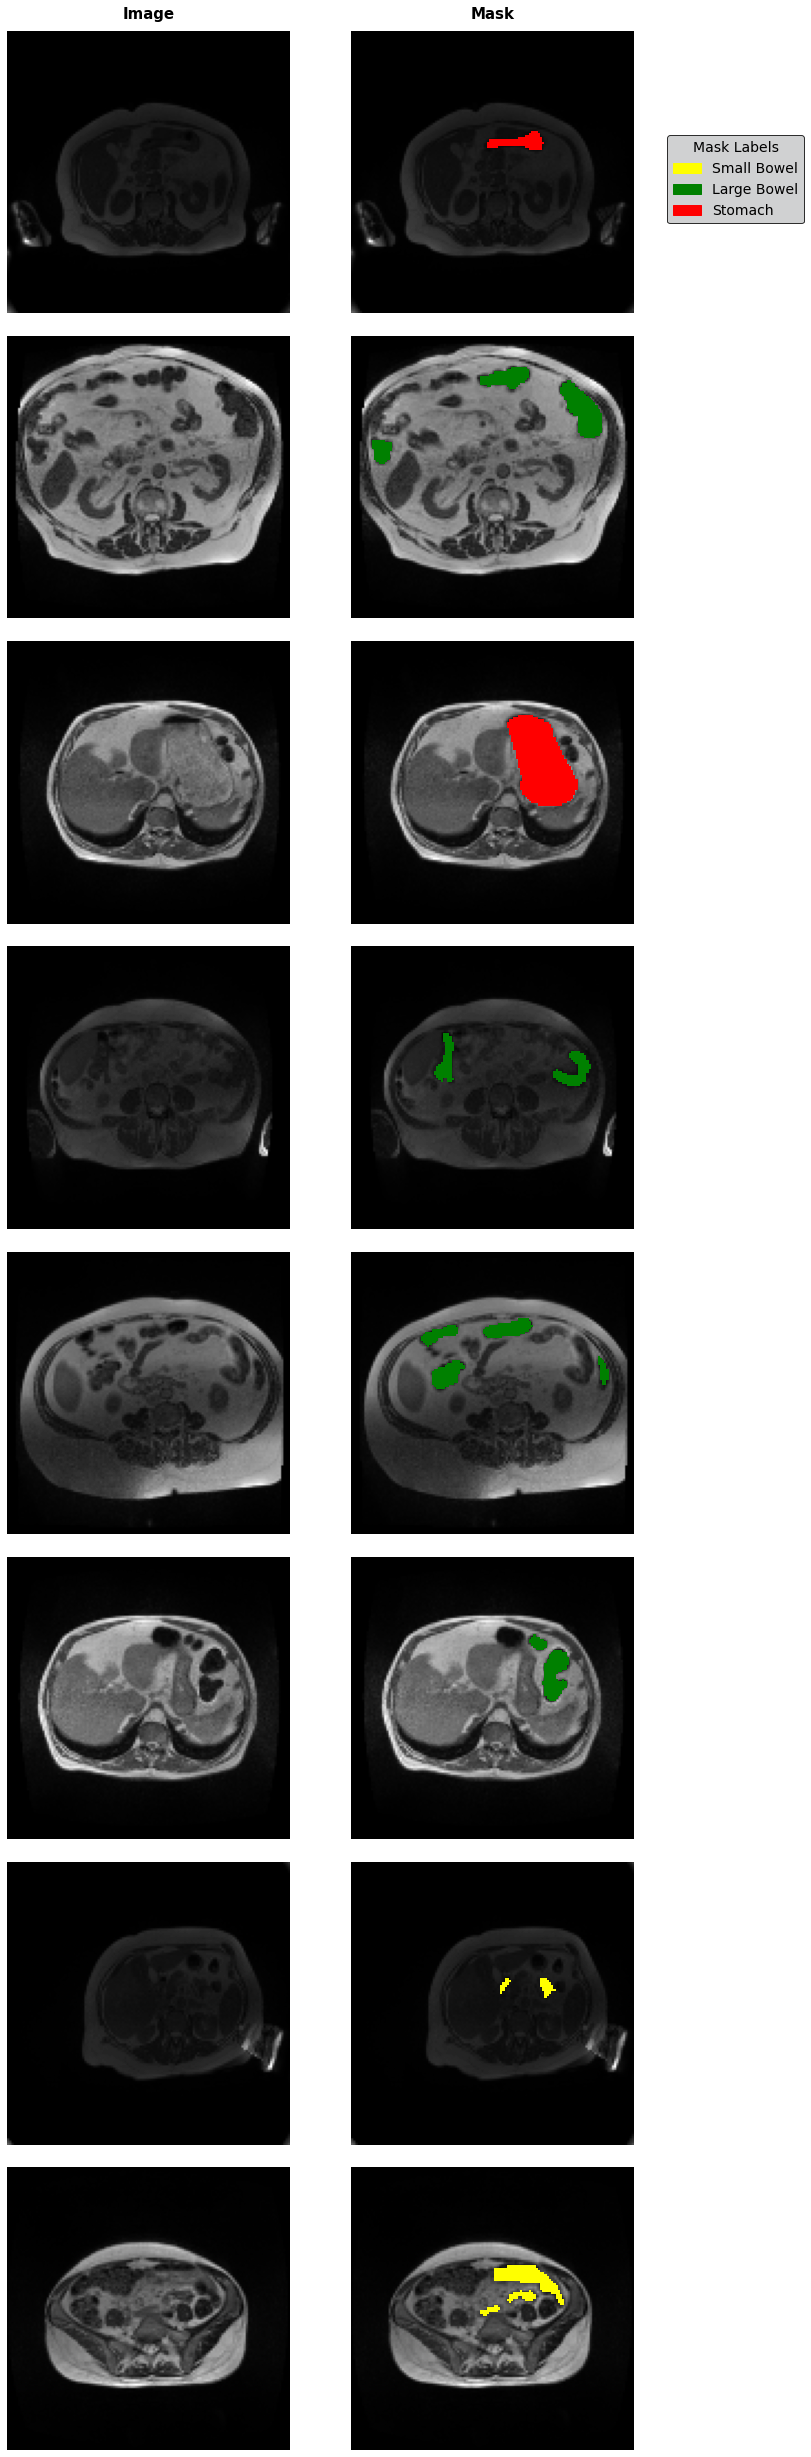

In [89]:
X, y = tmp_generator_class.__getitem__(1)

fig = plt.figure(figsize=(50, 40))
gs = gridspec.GridSpec(nrows=len(X), ncols=2)
colors = ['yellow','green','red']
labels = [ "Small Bowel","Large Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])
flag=False
for i in range(0,8):

    images, mask = X[i], y[i]
    sample_img=images/255.
    mask1=mask[:,:,0]
    mask2=mask[:,:,1]
    mask3=mask[:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img[:,:,0], cmap='gray')

    ax1 = fig.add_subplot(gs[i, 1])
    if(flag == False):
      flag= True
      ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
      ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
      plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img[:,:,0], cmap='gray')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
plt.subplots_adjust(left=0.11, bottom=0.08, right=0.3, top=0.92, wspace=0.01, hspace=0.08)

In [90]:
classes

['small_bowel', 'large_bowel', 'stomach']

In [91]:
coco.getCatIds(catNms=classes)

[0, 1, 2]

(8, 128, 128, 3)
(8, 128, 128, 3)
width:   128
height:  128
channel: 3


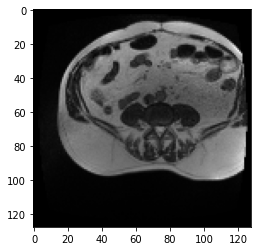

In [92]:
img_s, mask_s = test_generator_class.__getitem__(0)
# img_s, mask_s = next(tmp_generator)
print(img_s.shape)
print(mask_s.shape)
img = img_s[4]
h, w, c = img.shape
# print(img_s[0])
# print(img['id'])
# print(img[0].shape)
print('width:  ', w)
print('height: ', h)
print('channel:', c)
# plt.imshow(img[0][:, :,0])
plt.imshow(img[:,:,0], cmap='gray')

In [94]:
img_s, mask_s = train_generator_class.__getitem__(1)


fig = plt.figure(figsize=(20, 25))
gs = gridspec.GridSpec(nrows=len(img_s), ncols=2)
colors = ['yellow','green','red']
labels = [ "Small Bowel","Large Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])
flag=False
for i in range(1,7):

    images, mask = img_s[i], mask_s[i]
    sample_img=images/255.
    mask1=mask[:,:,0]
    mask2=mask[:,:,1]
    mask3=mask[:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img[:,:,0], cmap='gray')

    ax1 = fig.add_subplot(gs[i, 1])
    if(flag == False):
      flag= True
      ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
      ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
      plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img[:,:,0], cmap='gray')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

plt.subplots_adjust(left=0.11, bottom=0.08, right=0.3, top=0.92, wspace=0.01, hspace=0.08)    

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


In [95]:
img = cv2.imread(images_tmp[1]['file_name'], cv2.IMREAD_ANYDEPTH)
dsize = (128, 128)
img = cv2.resize(img, dsize)
img = img.astype(np.float32) / 255.
# img = np.expand_dims(img, axis=-1)
plt.imshow(img)

In [153]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import NoNorm

def visualizeGenerator(gen,batch_size):

    # img_, mask_ = next(gen)
    img_, mask_ = gen.__getitem__(batch_size)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)



    colors = ['yellow','green','red']
    labels = [ "Small Bowel","Large Bowel", "Stomach"]
    patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

    cmap1 = mpl.colors.ListedColormap(colors[0])
    cmap2 = mpl.colors.ListedColormap(colors[1])
    cmap3 = mpl.colors.ListedColormap(colors[2])


    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                # print('image')
                # print(img_[j].shape)
                ax.imshow(img_[j][:,:,0],cmap='gray')
                # ax.imshow(img_[j],cmap='gray')
            else:
                # ax.imshow(img_[j],cmap='gray')
                # ax.imshow(mask_[j])
                ax.imshow(img_[j][:,:,0],cmap='gray')

                mask1=mask_[j][:,:,0]
                mask2=mask_[j][:,:,1]
                mask3=mask_[j][:,:,2]

                l1 = ax.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
                l2 = ax.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
                l3 = ax.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)


            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


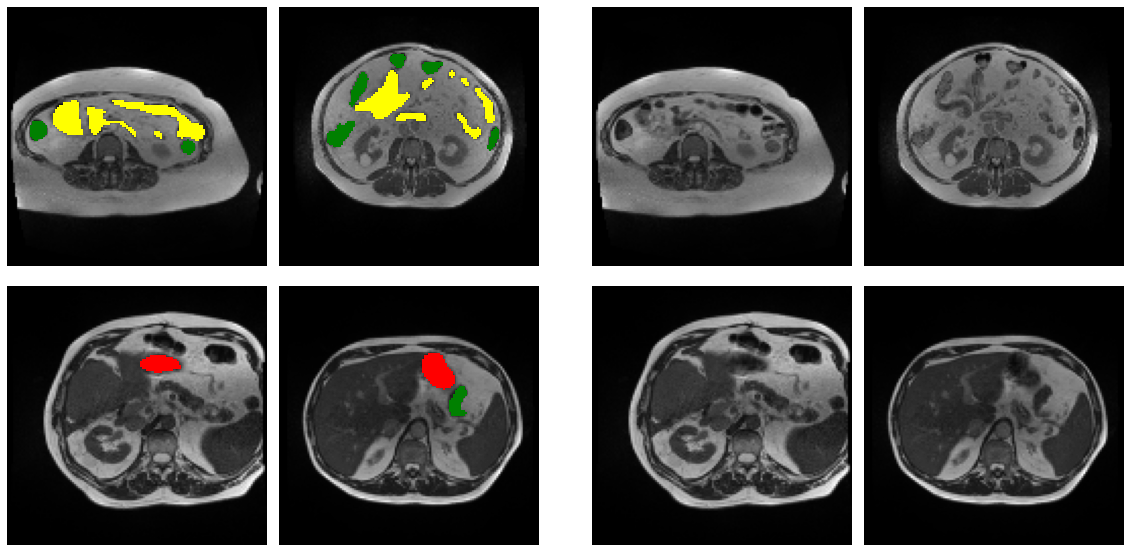

In [155]:
visualizeGenerator(train_generator_class,0)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


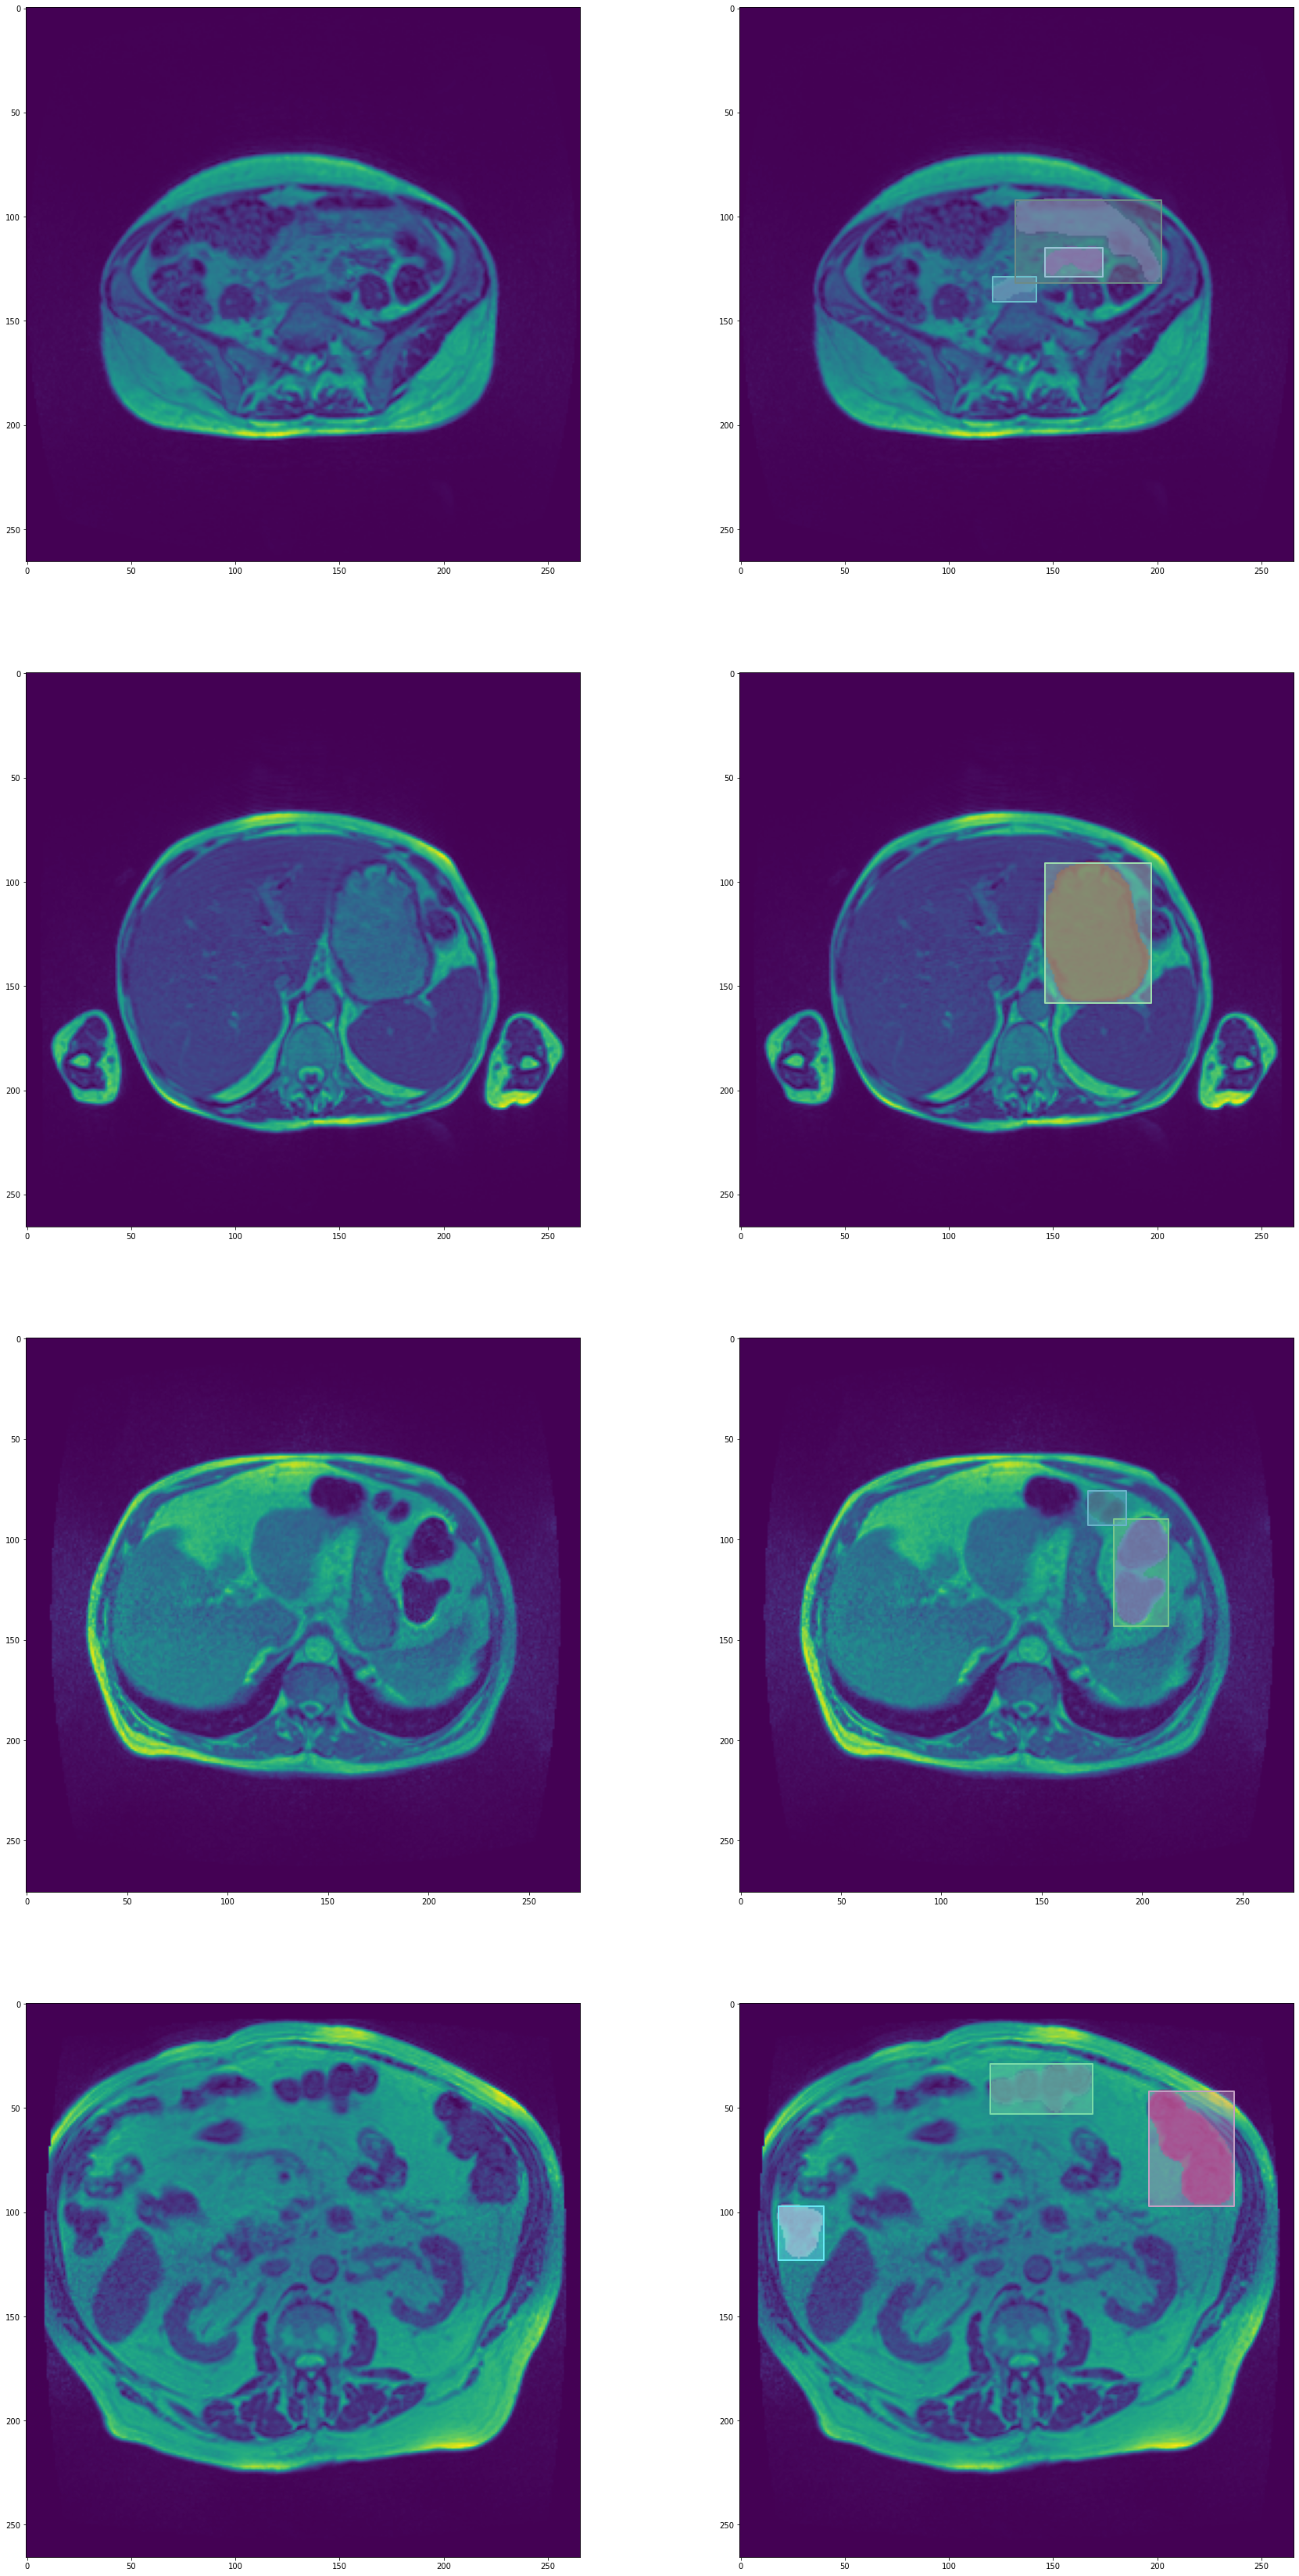

In [156]:
annFile = Path(f'/content/working/tmp_json.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()


imgs = coco.loadImgs(imgIds[0:4])
_,axs = plt.subplots(len(imgs),2,figsize=(30,15 * len(imgs)))
for img, ax in zip(imgs, axs):
#     I = Image.open(img['file_name'])
    I = Image.fromarray(np.array(Image.open(img['file_name'])).astype("uint16"))
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

In [157]:
! pip install --quiet segmentation-models

     |████████████████████████████████| 50 kB 6.8 MB/s 


In [158]:
! pip install --quiet  git+https://github.com/qubvel/segmentation_models

In [159]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [160]:
from keras import backend as K
from keras.losses import binary_crossentropy

# Metrics
dice_loss_fun = sm.losses.DiceLoss()
bce_loss_fun = sm.losses.BinaryCELoss()

def bce_dice_loss(y_true, y_pred):
    dice_loss = dice_loss_fun(y_true, y_pred)
    bce_loss = bce_loss_fun(y_true, y_pred)
    return 0.5 * dice_loss + 0.5 * bce_loss

# https://www.kaggle.com/code/ammarnassanalhajali/uwmgi-unet-keras-train-with-eda
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2. * intersection + smooth) \
        / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return coef
        

In [229]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('efficientnetb7',input_shape=(128, 128, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])

In [230]:
steps_per_epoch = dataset_size_train // batch_size
validation_steps = dataset_size_test // batch_size

In [163]:
steps_per_epoch

3391

In [ ]:
# steps_per_epoch = dataset_size_tmp // batch_size
# validation_steps = dataset_size_tmp // batch_size

In [231]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,TensorBoard,ModelCheckpoint

tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)

checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

reduce_lr = ReduceLROnPlateau(factor=0.2,monitor='val_loss',verbose=1,patience=5, min_lr=0.001)
# reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

early_stopping = EarlyStopping(monitor='loss',min_delta=0.0001, patience=5)

In [165]:
test_generator_class.dataset_size

6783

In [ ]:
history = model.fit(
                    train_generator_class,
                    validation_data = test_generator_class,


                    validation_steps = validation_steps,  
                    steps_per_epoch = steps_per_epoch , 
                    epochs = epochs,

                    callbacks=[tb_callback,reduce_lr,early_stopping,checkpoint],

                    batch_size = batch_size,
                    workers=4,
                    use_multiprocessing=False

                    )

In [210]:
print(history.history.keys())

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef', 'lr'])


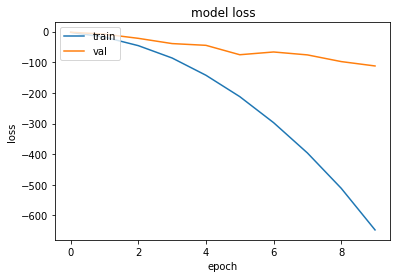

In [211]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for IOU
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('dice_coef iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/UW_Madison_segmentation/model_masks_class.h5')
# model.save('/content/model.h5')

In [241]:
from keras.models import load_model
model2 = load_model('/content/drive/MyDrive/UW_Madison_segmentation/model_masks_class.h5', custom_objects={'dice_coef':dice_coef,'bce_dice_loss':bce_dice_loss})


In [242]:
model = model2


In [ ]:
len(images_test)

6783

In [ ]:
# submission_df = test_df
# submission_df["segmentation"]=''
# submission_df=submission_df.rename(columns={"segmentation":"prediction"})
# submission_df= submission_df.drop(columns=['case_id','day_id',	'slice_id',	'filename'	,'unique_filename',	'size','Unnamed: 0'])
# submission_df.head()

In [258]:
test_generator_class = DataGeneratorFromCocoJson(batch_size,"train",images_test,classes,input_image_size,'/content/working/test_json.json')
img_s, mask_s = test_generator_class.__getitem__(87)
preds = model.predict(img_s)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [260]:
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=len(img_s), ncols=3)
colors = ['yellow','green','red']
labels = [ "Small Bowel","Large Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])
flag=False
for i in range(0,7):

    images, mask = img_s[i], mask_s[i]
    sample_img=images/255.
    mask1=mask[:,:,0]
    mask2=mask[:,:,1]
    mask3=mask[:,:,2]

    pre=preds[i]
    predict1=pre[:,:,0]
    predict1= (predict1 > 0.8).astype(np.float32)
    predict1 = np.array(predict1)
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]    
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img[:,:,0], cmap='gray')

    ax1 = fig.add_subplot(gs[i, 1])
    ax2 = fig.add_subplot(gs[i, 2])
    if(flag == False):
      flag= True
      ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
      ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
      ax2.set_title("predicted Mask", fontsize=15, weight='bold', y=1.02)
      plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img[:,:,0], cmap='gray')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)

    l0 = ax2.imshow(sample_img[:,:,0], cmap='gray')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)    
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


In [270]:
# Run-length encoding
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [ ]:
test_generator_class.indexes

array([   0,    1,    2, ..., 6780, 6781, 6782])

In [ ]:
submission_df[submission_df['id'] ==1]

id                  file_id  width  height  \
6267  1.0  case119_day0_slice_0113  360.0   310.0   

                                              file_name  predictions  \
6267  /content/uw-madison-gi-tract-image-segmentatio...          NaN   

                                             prediction  
6267  12377 2 12643 2 16870 6 17136 6 17400 8 17456 ...

In [ ]:
def gettest(elem,id):
    for i in elem:
      if(i['id']==id):
        return i
    return None

'/content/uw-madison-gi-tract-image-segmentation/case119/case119_day0/scans/slice_0113_360_310_1.50_1.50.png'

In [266]:
import gc
test_generator_class = DataGeneratorFromCocoJson(1,"test",images_test,classes,input_image_size,'/content/working/test_json.json')
gc.collect()
LOGITS = model.predict(test_generator_class,verbose=1)
gc.collect()

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
6783/6783 [==============================] - 257s 37ms/step


4

In [262]:
images_test, dataset_size_test, coco_val = filterDataset( classes,  '/content/working/test_json.json')

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [286]:
submission_df = pd.DataFrame.from_records(images_test) 
submission_df.insert(5,'prediction', np.nan)
submission_df.insert(3,'class_name', np.nan)
submission_df.head()

id                   file_id  width  class_name  height  \
0  2015    case9_day20_slice_0089    360         NaN     310   
1  5058  case122_day27_slice_0047    266         NaN     266   
2  1921  case129_day24_slice_0109    360         NaN     310   
3  6332  case131_day23_slice_0072    360         NaN     310   
4  2146    case30_day1_slice_0083    266         NaN     266   

                                           file_name  prediction  
0  /content/uw-madison-gi-tract-image-segmentatio...         NaN  
1  /content/uw-madison-gi-tract-image-segmentatio...         NaN  
2  /content/uw-madison-gi-tract-image-segmentatio...         NaN  
3  /content/uw-madison-gi-tract-image-segmentatio...         NaN  
4  /content/uw-madison-gi-tract-image-segmentatio...         NaN

In [287]:
submission_df.shape

(6783, 7)

In [281]:
lbs = []
sbs = []
sts = []
for index, row in tqdm(submission_df.iterrows(), total=submission_df.shape[0]):
    root_shape = (submission_df.iloc[index]["height"], submission_df.iloc[index]["width"])
    pred_arr = np.round(cv2.resize(LOGITS[index,:, :,0], root_shape, interpolation=cv2.INTER_NEAREST)).astype('uint8')
    lbs.append(rle_encode(pred_arr))
    pred_arr = np.round(cv2.resize(LOGITS[index,:, :,1], root_shape, interpolation=cv2.INTER_NEAREST)).astype('uint8')
    sbs.append(rle_encode(pred_arr))
    pred_arr = np.round(cv2.resize(LOGITS[index,:, :,2], root_shape, interpolation=cv2.INTER_NEAREST)).astype('uint8')
    sts.append(rle_encode(pred_arr))


100%|██████████| 6783/6783 [00:17<00:00, 391.88it/s]


In [288]:
ids = []
classes = []
rles = []
for index, row in tqdm(submission_df.iterrows(), total=submission_df.shape[0]):
    ids.extend([row['file_id']] * 3)
    classes.extend(['large_bowel', 'small_bowel', 'stomach'])
    rles.extend([lbs[index], sbs[index], sts[index]])

100%|██████████| 6783/6783 [00:00<00:00, 21823.85it/s]


In [289]:
submission_df = pd.DataFrame()
submission_df['id'] = ids
submission_df['class'] = classes
submission_df['predicted'] = rles
# submission_df = submission_df.reset_index(drop=True)
submission_df.to_csv("submission.csv", index=False)

In [291]:
submission_df.sample(25)

id        class  \
5395    case44_day20_slice_0097  small_bowel   
9822    case19_day18_slice_0070  large_bowel   
17259  case101_day22_slice_0097  large_bowel   
2353    case130_day0_slice_0093  small_bowel   
18973  case122_day27_slice_0052  small_bowel   
18295   case20_day22_slice_0118  small_bowel   
531     case85_day21_slice_0105  large_bowel   
5582    case18_day17_slice_0103      stomach   
19479   case140_day0_slice_0075  large_bowel   
4291   case138_day12_slice_0064  small_bowel   
6504      case2_day4_slice_0069  large_bowel   
2443    case43_day26_slice_0090  small_bowel   
13152   case36_day14_slice_0090  large_bowel   
16233  case122_day18_slice_0072  large_bowel   
16190   case24_day25_slice_0065      stomach   
5126    case63_day20_slice_0085      stomach   
3297   case108_day10_slice_0079  large_bowel   
7102    case81_day30_slice_0078  small_bowel   
10999   case35_day12_slice_0034  small_bowel   
13880    case53_day0_slice_0099      stomach   
715     case54_day30_slice_0083  small_bowel   
2974   case139_day16_slice_0069  small_bowel   
3812    case47_day27_slice_0035      stomach   
2386    case35_day15_slice_0045  small_bowel   
18034  case144_day15_slice_0100  small_bowel   

                                               predicted  
5395   25658 23 25687 4 25924 23 25953 4 26190 21 262...  
9822   35230 12 35540 12 35850 12 36160 17 36470 17 3...  
17259  20045 4 20311 4 20569 12 20835 12 21099 14 213...  
2353   29114 12 29380 12 29619 58 29885 58 30147 68 3...  
18973  28358 2 28624 2 28890 2 29685 3 29951 3 30217 ...  
18295  20575 2 20841 2 21092 21 21358 21 21624 21 218...  
531    17975 2 18241 2 18488 21 18754 21 19018 9 1902...  
5582                                                      
19479  22443 4 22709 4 22975 4 23094 4 23241 4 23360 ...  
4291   27875 2 28141 2 28407 2 28673 2 28939 2 29205 ...  
6504     30760 4 31026 4 31290 8 31556 8 31824 6 32090 6  
2443   29097 2 29363 2 29625 8 29891 8 30155 13 30421...  
13152  17952 4 18218 4 18470 6 18736 6 19000 4 19266 ...  
16233  21996 9 22262 9 22528 15 22794 15 23060 21 233...  
16190  18495 6 18761 6 19023 20 19289 20 19555 25 198...  
5126   18513 11 18779 11 19041 21 19095 9 19307 21 19...  
3297   15872 6 16138 6 16404 2 16408 2 16670 2 16674 ...  
7102   22574 2 22840 2 23106 2 23372 2 23638 2 23904 ...  
10999  32912 5 33188 5 33462 11 33738 11 34012 15 342...  
13880                                                     
715    20600 6 20866 6 21128 16 21394 16 21660 16 219...  
2974   30220 2 30486 2 30687 6 30953 6 31217 12 31281...  
3812   46647 5 46957 5 47264 10 47574 10 47884 10 481...  
2386   24719 2 24762 2 24995 2 25038 2 25268 3 25314 ...  
18034  31190 2 31456 2 31718 10 31984 10 32248 14 325...